In [20]:
import hydra
import torch
from tqdm.notebook import tqdm
from lib.utils.config import load_config
from lib.optimizer.framework import NeuralOptimizer
from lib.data.loader import load_intrinsics
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera
from lib.tracker.timer import TimeTracker
from lib.utils.progress import reset_progress, close_progress


def path_to_abblation(path):
    return "_".join(path.split("/")[-3].split("_")[1:])


def eval_iterations(optimizer, datamodule, N: int = 1, mode="iters"):
    optimizer.max_iters = 1
    optimizer.max_optims = 1

    outer_progress = tqdm(total=N + 1, desc="Iter Loop", position=0)
    total_evals = len(datamodule.val_dataset)
    inner_progress = tqdm(total=total_evals, desc="Eval Loop", leave=True, position=1)

    iters_p_loss = {}
    iters_v_loss = {}
    iters_time = {}

    # initial evaluation no optimization
    reset_progress(inner_progress, total_evals)
    p_loss = []
    v_loss = []
    for batch in datamodule.val_dataloader():
        with torch.no_grad():
            batch = optimizer.transfer_batch_to_device(batch, "cuda", 0)
            out = optimizer(batch)
            out["params"] = batch["init_params"]
            loss_info = optimizer.compute_loss(batch=batch, out=out)
            p_loss.append(loss_info["loss_param"])
            v_loss.append(loss_info["loss_vertices"])
        inner_progress.update(1)
    iters_p_loss[0] = torch.stack(p_loss)
    iters_v_loss[0] = torch.stack(v_loss)
    iters_time[0] = torch.zeros_like(iters_p_loss[0])
    outer_progress.update(1)

    # evaluation after some optimization
    for iters in range(1, N + 1):
        reset_progress(inner_progress, total_evals)
        if mode == "iters":
            optimizer.max_iters = iters
        else:
            optimizer.max_optims = iters
        time_tracker = TimeTracker()
        p_loss = []
        v_loss = []
        for batch in datamodule.val_dataloader():
            with torch.no_grad():
                batch = optimizer.transfer_batch_to_device(batch, "cuda", 0)
                time_tracker.start("optimize")
                out = optimizer(batch)
                time_tracker.stop("optimize")
                loss_info = optimizer.compute_loss(batch=batch, out=out)
                p_loss.append(loss_info["loss_param"])
                v_loss.append(loss_info["loss_vertices"])
            inner_progress.update(1)
        iters_p_loss[iters] = torch.stack(p_loss)
        iters_v_loss[iters] = torch.stack(v_loss)
        iters_time[iters] = torch.stack(
            [torch.tensor(t.time_ms) for t in list(time_tracker.tracks.values())[0]]
        )
        outer_progress.update(1)
    close_progress([outer_progress, inner_progress])
    return iters_p_loss, iters_v_loss, iters_time


def load_flame_renderer():
    # instanciate similar to training
    cfg = load_config("train", ["data=synthetic"])
    K = load_intrinsics(data_dir=cfg.data.intrinsics_dir, return_tensor="pt")
    camera = Camera(
        K=K,
        width=cfg.data.width,
        height=cfg.data.height,
        near=cfg.data.near,
        far=cfg.data.far,
        scale=cfg.data.scale,
    )
    rasterizer = Rasterizer(width=camera.width, height=camera.height)
    renderer = Renderer(rasterizer=rasterizer, camera=camera)
    flame = hydra.utils.instantiate(cfg.model)
    return flame, renderer


def load_neural_optimizer(flame, renderer, path, override=[]):
    o = ["data=synthetic"] + override
    cfg = load_config("train", o)
    correspondence = hydra.utils.instantiate(cfg.correspondence)
    weighting = hydra.utils.instantiate(cfg.weighting)
    residuals = hydra.utils.instantiate(cfg.residuals)
    regularize = hydra.utils.instantiate(cfg.regularize)
    neural_optimizer = NeuralOptimizer.load_from_checkpoint(
        path,
        renderer=renderer,
        flame=flame,
        correspondence=correspondence,
        regularize=regularize,
        residuals=residuals,
        weighting=weighting,
    )
    return neural_optimizer

def load_icp_optimizer(flame, renderer, overrides):
    cfg = load_config(
        "train", ["data=synthetic", "optimizer.output_dir=none"] + overrides
    )
    correspondence = hydra.utils.instantiate(cfg.correspondence)
    weighting = hydra.utils.instantiate(cfg.weighting)
    residuals = hydra.utils.instantiate(cfg.residuals)
    optimizer = hydra.utils.instantiate(cfg.optimizer)
    regularize = hydra.utils.instantiate(cfg.regularize)
    icp_optimizer = hydra.utils.instantiate(
        cfg.framework,
        flame=flame,
        logger=None,
        renderer=renderer,
        correspondence=correspondence,
        regularize=regularize,
        residuals=residuals,
        optimizer=optimizer,
        weighting=weighting,
    )
    return icp_optimizer.to("cuda")


# setup the datamodule
def load_datamodule(renderer, start_frame, end_frame):
    cfg = load_config("train", ["data=synthetic"])
    datamodule = hydra.utils.instantiate(
        cfg.data,
        renderer=renderer,
        val_dataset=dict(
            start_frame=start_frame,
            end_frame=end_frame,
        ),
    )
    datamodule.setup("fit")
    return datamodule

In [17]:
# settings
N = 10
step_size = 0.7
start_frame = 10
end_frame = 18

# checkpoints
wo_neural_weights = "/home/borth/GuidedResearch/checkpoints/synthetic_lr/wo_neural_weights.ckpt"
ours = "/home/borth/GuidedResearch/checkpoints/synthetic_lr/ours2.ckpt"

# loadings
times = {}
p_losses = {}
v_losses = {}
flame, renderer = load_flame_renderer()
datamodule = load_datamodule(renderer, start_frame, end_frame)

Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01


In [19]:
path = ours
optimizer = load_neural_optimizer(flame, renderer, path)
optimizer.optimizer.step_size = step_size
p_loss, v_loss, time = eval_iterations(optimizer, datamodule, N=N, mode="iters")
key = "ours"
times[key] = time[N].median().item()
p_losses[key] = {k: v.mean().item() for k, v in p_loss.items()}
v_losses[key] = {k: v.mean().item() for k, v in v_loss.items()}

path = wo_neural_weights
overrides = ["weighting.dummy_weight=True"]
optimizer = load_neural_optimizer(flame, renderer, path, overrides)
optimizer.optimizer.step_size = step_size
p_loss, v_loss, time = eval_iterations(optimizer, datamodule, N=N, mode="iters")
key = "wo_neural_weights"
times[key] = time[N].median().item()
p_losses[key] = {k: v.mean().item() for k, v in p_loss.items()}
v_losses[key] = {k: v.mean().item() for k, v in v_loss.items()}

overrides = ["weighting=dummy", "regularize=dummy"]
optimizer = load_icp_optimizer(flame, renderer, overrides)
optimizer.optimizer.step_size = step_size
p_loss, v_loss, time = eval_iterations(optimizer, datamodule, N=N)
key = "icp-f2f"
p_losses[key] = {k: v.mean().item() for k, v in p_loss.items()}
v_losses[key] = {k: v.mean().item() for k, v in v_loss.items()}

overrides = ["residuals=point2plane", "weighting=dummy", "regularize=dummy"]
optimizer = load_icp_optimizer(flame, renderer, overrides)
optimizer.optimizer.step_size = step_size
p_loss, v_loss, time = eval_iterations(optimizer, datamodule, N=N)
key = "icp-p2p"
p_losses[key] = {k: v.mean().item() for k, v in p_loss.items()}
v_losses[key] = {k: v.mean().item() for k, v in v_loss.items()}

data = dict(p_losses=p_losses, v_losses=v_losses)
torch.save(data, "results/optimization_iterations.pth")

Iter Loop:   0%|          | 0/11 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/64 [00:00<?, ?it/s]

Iter Loop:   0%|          | 0/11 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/64 [00:00<?, ?it/s]

Iter Loop:   0%|          | 0/11 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/64 [00:00<?, ?it/s]

Iter Loop:   0%|          | 0/11 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/64 [00:00<?, ?it/s]

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch
import torch

# Load the data
p_losses = torch.load("/home/borth/GuidedResearch/results/optimization_iterations.pth")["p_losses"]

# store the data
data = {}
data["Ours w/ neural weight"] = p_losses["ours"]
data["Ours w/o neural weight"] = p_losses["wo_neural_weights"]
data["ICP w/ reg."] = p_losses["icp-f2f"]
data["ICP w/o reg."] = p_losses["icp-p2p"]

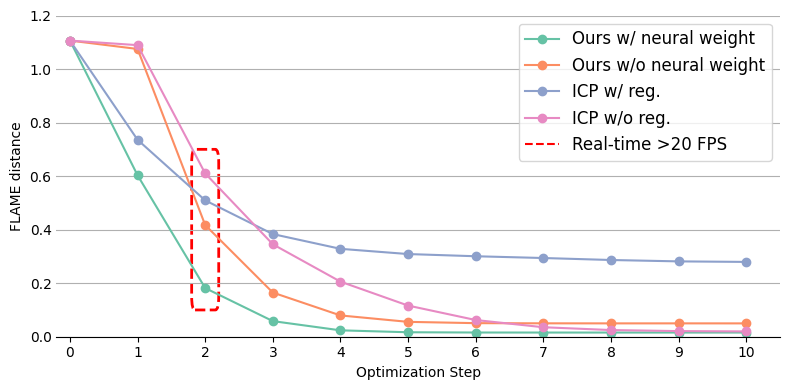

In [2]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot each line
colors = plt.get_cmap("Set2", 8)  # 8
for i, (label, values) in enumerate(data.items()):
    x = list(values.keys())  # X axis (the steps, 0, 1, 2)
    y = list(values.values())  # Y axis (the corresponding values)
    ax.plot(
        x,
        y,
        label=label,
        marker="o",
        linestyle="-",
        linewidth=1.5,
        color=colors.colors[i],
    )

# Add labels and title
ax.set_xlabel("Optimization Step")
ax.set_ylabel("FLAME distance")
ax.legend()

# Show the plot
ax.set_ylim(bottom=0, top=1.2)  # Set minimum y-axis limit to 0
ax.set_xlim(left=-0.2)  # Set minimum y-axis limit to 0
ax.yaxis.grid(True)


# Highlight the points at step size 2 with a red dotted box
box_x = [1.8, 2.2]  # x-coordinate limits for the box
box_y = [0.10, 1.0]  # y-coordinate limits for the box
box_width = 0.4  # Width of the box
box_height = 0.6  # Height of the box

# Create a red dotted rectangle
rect = Rectangle(
    (box_x[0], box_y[0]),
    box_width,
    box_height,
    linewidth=2,
    edgecolor="red",
    facecolor="none",
    linestyle="--",
)
rect = FancyBboxPatch(
    (box_x[0], box_y[0]),  # Position
    box_width,             # Width of the rectangle
    box_height,            # Height of the rectangle
    boxstyle="round,pad=0.0,rounding_size=0.05",  # Rounded corners
    linewidth=2,           # Border thickness
    edgecolor="red",       # Border color
    facecolor="none",       # Background color (red)
    alpha=1.0,             # Opacity of the background (30%)
    linestyle="--"         # Dotted border style
)
ax.add_patch(rect)

# Remove spines for left, right, and top
ax.spines["top"].set_visible(False)  # Hide the top spine
ax.spines["right"].set_visible(False)  # Hide the right spine
ax.spines["left"].set_visible(False)  # Hide the left spine
ax.spines["bottom"].set_visible(True)

# Remove tick marks on the y-axis
ax.tick_params(axis="y", direction="in", length=0)  # Set tick length to 0 to hide them
legend_elements = plt.Line2D([0], [0], color="red", linestyle="--", label="Real-time <50 ms")
ax.legend(
    handles=ax.get_legend_handles_labels()[0] + [legend_elements],
    fontsize="12",
    loc="upper right",
)
ax.set_xticks(range(0, 11))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("results/optimization_iterations.pdf", format="pdf")
plt.show()